In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import shap
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from xgboost import XGBClassifier
import optuna
from imblearn.over_sampling import SMOTE
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class FeatureWeighting(Layer):
    def __init__(self, input_dim, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim

    def build(self, input_shape):
        self.feature_weights = self.add_weight(
            shape=(self.input_dim,), initializer='ones', trainable=True, name='feature_weights')

    def call(self, inputs):
        return inputs * self.feature_weights
class FraudDetectionFramework:
    def __init__(self, df, target_column="Class", config=None):
        self.df = df.copy()
        self.target_column = target_column
        self.config = config or {}
        self.scale_pos_weight = self.config.get('xgb_weight', 50)
        self.scaler = MinMaxScaler()
        self.output_dir = self.config.get("output_dir", "output")
        os.makedirs(self.output_dir, exist_ok=True)

        self.X = self.df.drop(columns=[self.target_column])
        self.y = self.df[self.target_column]
        if self.y.isnull().sum() > 0:
            self.y.fillna(self.y.mode()[0], inplace=True)

        self.X = self._handle_non_numeric_features(self.X)
        self._print_class_distribution()
        self._calculate_class_weight()

    def _handle_non_numeric_features(self, X):
        for col in X.columns:
            if X[col].dtype == 'object' or X[col].dtype.name == 'category':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
        return X

    def _print_class_distribution(self):
        print("Class Distribution:\n", self.y.value_counts(normalize=True))

    def _calculate_class_weight(self):
        print(f"Calculated scale_pos_weight: {self.scale_pos_weight:.2f}")

    def impute_and_scale(self):
        imp = IterativeImputer(random_state=42, max_iter=self.config.get("imputer_iter", 10))
        X_imputed = imp.fit_transform(self.X)
        self.X_scaled = self.scaler.fit_transform(X_imputed)

    def split_data(self):
        for seed in range(42, 52):
            X_train, X_test, y_train, y_test = train_test_split(
                self.X_scaled, self.y, test_size=0.2, stratify=self.y, random_state=seed)
            if y_test.value_counts().get(1, 0) > 0:
                self.X_train, self.X_test = X_train, X_test
                self.y_train, self.y_test = y_train, y_test
                break
            else:
                raise ValueError("No class 1 in test set after multiple attempts")

        if self.config.get("apply_smote", True):
            smote = SMOTE(random_state=42)
            self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)
    def build_autoencoder(self):
        input_dim = self.X_train.shape[1]
        encoding_ratio = self.config.get("encoding_ratio", 0.75)
        encoding_dim = int(input_dim * encoding_ratio)
        dropout_rate = self.config.get("dropout", 0.3)

        input_layer = Input(shape=(input_dim,))
        x = FeatureWeighting(input_dim)(input_layer)
        x = Dense(encoding_dim * 4, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        encoded = Dense(encoding_dim, activation='relu', name="encoded")(x)
        x = Dense(encoding_dim * 4, activation='relu')(encoded)
        decoded = Dense(input_dim, activation='sigmoid')(x)

        self.ae_model = Model(input_layer, decoded)
        self.ae_model.compile(optimizer=Adam(learning_rate=self.config.get("lr", 1e-3)), loss='mse')
    def weighted_mse(self,y_true,y_pred):
        weight_for_class1=30.0
        is_class1=K.cast(K.equal(y_true,1),'float32')
        weight=1.0+is_class1 * (weight_for_class1 - 1.0)
        return  K.mean(weight * K.square(y_true - y_pred), axis=-1)
    def train_autoencoder(self):
        if self.config.get("ae_weighted_loss", True):
            w_majority = self.config.get("ae_class0_weight", 1.0)
            w_minority = self.config.get("ae_class1_weight", 5.0)

            self.sample_weights = np.where(
                self.y_train.values == 0, w_majority, w_minority
            )

        else:
            self.sample_weights = None

        self.ae_model.compile(
            optimizer=Adam(learning_rate=self.config.get("lr", 1e-3)),
            loss=self.weighted_mse
        )
        early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
        self.ae_history=self.ae_model.fit(
            self.X_train,
            self.X_train,
            sample_weight=self.sample_weights,
            epochs=self.config.get("ae_epochs", 50),
            batch_size=self.config.get("batch_size", 32),
            shuffle=True,
            validation_split=0.2,
            verbose=0,
            callbacks=[early_stopping]
        )
    def extract_combined_features(self, X,is_train=True):
        encoder = Model(inputs=self.ae_model.input, outputs=self.ae_model.get_layer("encoded").output)
        encoded = encoder.predict(X)
        if is_train:
          # محاسبه خطای بازسازی به‌عنوان ویژگی جدید
          reconstructed = self.ae_model.predict(X)
          error = np.mean(np.square(X - reconstructed), axis=1).reshape(-1, 1)
        else:
          error=np.zeros((X.shape[0],1))
        # ترکیب ویژگی‌های encoding و خطای بازسازی
        return np.concatenate([encoded, error], axis=1)

    def optimize_xgboost(self, X_train, y_train):
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "gamma": trial.suggest_float("gamma", 0, 10),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "scale_pos_weight": self.scale_pos_weight,  # متوازن‌سازی کلاس‌ها
                "eval_metric": "logloss"
            }
            model = XGBClassifier(**params)
            minority_class_count = np.min(np.bincount(y_train))
            n_splits = min(5, minority_class_count)
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            return cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(f1_score)).mean()

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50)
        self.xgb_study=study

        print("✅ Best parameters found by Optuna:")
        print(study.best_params)

        # ساخت مدل نهایی با بهترین پارامترها
        self.xgb_model = XGBClassifier(**study.best_params)
        self.xgb_model.fit(X_train, y_train)

    def evaluate_model(self, X_test, y_test):
        y_pred = self.xgb_model.predict(X_test)

        print("\n📊 Evaluation Report:\n")
        print(classification_report(y_test, y_pred, digits=4))

        try:
            proba = self.xgb_model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, proba)
        except Exception as e:
            auc = "N/A"
            print("⚠️ ROC AUC محاسبه نشد:", e)

        print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
        print("Precision:", round(precision_score(y_test, y_pred), 4))
        print("Recall:", round(recall_score(y_test, y_pred), 4))
        print("F1 Score:", round(f1_score(y_test, y_pred), 4))
        print("ROC AUC:", auc)
    def select_important_features(self, threshold=0.001, top_k_if_none=10):
        print("\n🔍 Computing permutation importance on combined features...")
        result = permutation_importance(
            self.xgb_model,
            self.X_test_combined,
            self.y_test,
            n_repeats=20,
            random_state=42,
            scoring='f1'
        )

        importances = result.importances_mean
        feature_names = [f"F{i}" for i in range(len(importances))]

        self.perm_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values("Importance", ascending=False)

        print("\n📊 Permutation Importance Scores:")
        print(self.perm_df)

        # استخراج ایندکس ویژگی‌های مهم
        important_indices = np.where(importances >= threshold)[0].tolist()

        #  اگر هیچ ویژگی انتخاب نشد، top_k_if_none ویژگی مهم رو بگیر
        if len(important_indices) == 0:
            print(f"⚠️ هیچ ویژگی‌ای بالاتر از آستانه {threshold} نبود. انتخاب {top_k_if_none} ویژگی برتر.")
            important_indices = np.argsort(importances)[::-1][:top_k_if_none].tolist()

        self.selected_feature_indices = important_indices
        self.X_train_selected = self.X_train_combined[:, important_indices]
        self.X_test_selected = self.X_test_combined[:, important_indices]
        self.selected_feature_names = [f"F{i}" for i in important_indices]

        print(f"\n✅ Selected {len(important_indices)} features out of {len(importances)}")
    def retrain_on_selected_features(self):
        print("\n🔁 Retraining XGBoost on selected features...")
        self.xgb_model.fit(self.X_train_selected, self.y_train)
        self.evaluate_model(self.X_test_selected, self.y_test)

    def save_best_params(self,path="best_params.pkl"):
      if hasattr(self,'xgb_study'):
        joblib.dum(self.xgb_study.best_params,path)
        print(f"✅Best parameters saved to {path}")
      else:
        print("⚠️Study not found.Please run optimize_xgboost() first.")

    def plot_autoencoder_loss(self):
        plt.figure()
        plt.plot(self.ae_history.history['loss'], label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('AutoEncoder Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix")
        plt.show()


    def plot_reconstruction_error_distribution(self, encoded_train, encoded_test, y_train, y_test):
        reconstruction_train = encoded_train[:, -1]
        reconstruction_test = encoded_test[:, -1]

        reconstruction_error = np.concatenate([reconstruction_train, reconstruction_test])
        labels = np.concatenate([y_train, y_test])

        plt.figure(figsize=(8, 5))
        sns.kdeplot(reconstruction_error[labels == 0], label='Class 0')
        sns.kdeplot(reconstruction_error[labels == 1], label='Class 1')
        plt.title("Reconstruction Error Distribution by Class")
        plt.xlabel("Reconstruction Error")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

    def analyze_selected_features(self, X_selected, y_true, selected_feature_names):
      df_plot = pd.DataFrame(X_selected, columns=selected_feature_names)
      df_plot["class"] = y_true.values if hasattr(y_true, 'values') else y_true

      for col in selected_feature_names:
          plt.figure(figsize=(7, 4))
          sns.boxplot(x="class", y=col, data=df_plot)
          plt.title(f"Boxplot of {col} by Class")
          plt.show()

          plt.figure(figsize=(7, 4))
          sns.violinplot(x="class", y=col, data=df_plot)
          plt.title(f"Violinplot of {col} by Class")
          plt.show()

    def plot_shap_summary(self, X, y, num_individuals=3):
          X = np.array(X)
          if isinstance(y, pd.DataFrame):
              y = y.values.ravel()
          elif isinstance(y, pd.Series):
              y = y.values  # تضمین اینکه y آرایه‌ای باشه

          explainer = shap.Explainer(self.xgb_model)
          shap_values = explainer(X)

          mask = (y == 1)
          if not mask.any():  #  اینجا مطمئن شدیم mask فقط True/False array هست
              print("⚠️ هیچ نمونه‌ای با کلاس ۱ در داده‌ها وجود ندارد.")
              return

          print("📊 SHAP Summary Plot برای کلاس ۱:")
          shap.summary_plot(shap_values[mask], X[mask], plot_type="bar")

          indices = np.where(mask)[0][:num_individuals]
          for i in indices:
              print(f"\n📍 Waterfall Plot برای نمونه شماره {i} (کلاس ۱):")
              shap.plots.waterfall(shap_values[i])


    def run_pipeline(self):
        print("\n🔧 مرحله ۱: پیش‌پردازش داده‌ها")
        self.impute_and_scale()
        self.split_data()

        print("\n🧠 مرحله ۲: آموزش AutoEncoder با وزن‌دهی کلاس‌ها")
        self.build_autoencoder()
        self.train_autoencoder()

        print("\n📥 مرحله ۳: استخراج ویژگی‌های پنهان + خطای بازسازی")
        self.encoded_train = self.extract_combined_features(self.X_train,is_train=True)
        self.encoded_test = self.extract_combined_features(self.X_test,is_train=False)
        self.X_train_combined=self.encoded_train
        self.X_test_combined=self.encoded_test


        print("\n⚙️ مرحله ۴: تنظیم و آموزش XGBoost روی ویژگی‌های ترکیبی")
        self.optimize_xgboost(X_train=self.encoded_train, y_train=self.y_train)

        print("\n📊 مرحله ۵: ارزیابی نهایی مدل")
        self.evaluate_model(X_test=self.encoded_test, y_test=self.y_test)
        print("\n📊 ماتريس درهم ريختگي پس از آموزش اوليه")
        self.plot_confusion_matrix(self.y_test,self.xgb_model.predict(self.encoded_test))
        print("\n📊 مرحله ۶: ویژگی های مهم")
        self.select_important_features(threshold=0.001)
        self.retrain_on_selected_features()
        #plots
        self.plot_autoencoder_loss()                     # نمودار loss
        self.plot_confusion_matrix(self.y_test, self.xgb_model.predict(self.X_test_selected))
        self.plot_reconstruction_error_distribution(self.encoded_train, self.encoded_test, self.y_train, self.y_test)
        self.analyze_selected_features(self.X_train_selected, self.y_train, self.selected_feature_names)
        self.plot_shap_summary(self.X_test_selected, self.y_test, num_individuals=5)

In [6]:


# بارگذاری دیتاست
df = pd.read_csv("creditcard.csv")

# ساخت چارچوب تشخیص تقلب
framework = FraudDetectionFramework(df, target_column="Class", config={
    "output_dir": "output",
    "encoding_ratio": 0.75,
    "dropout": 0.3,
    "lr": 1e-3,
    "ae_epochs": 50,
    "batch_size": 32,
    "ae_class0_weight": 1.0,
    "ae_class1_weight": 10.0,
    "ae_weighted_loss": True,
    "xgb_weight": 70  # وزن کلاس اقلیت برای XGBoost
})

Class Distribution:
 Class
0.0    0.996069
1.0    0.003931
Name: proportion, dtype: float64
Calculated scale_pos_weight: 70.00



🔧 مرحله ۱: پیش‌پردازش داده‌ها

🧠 مرحله ۲: آموزش AutoEncoder با وزن‌دهی کلاس‌ها

📥 مرحله ۳: استخراج ویژگی‌های پنهان + خطای بازسازی
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-07-06 20:29:46,879] A new study created in memory with name: no-name-976b6bc6-61ee-4fa6-b4bd-bd279002c200



⚙️ مرحله ۴: تنظیم و آموزش XGBoost روی ویژگی‌های ترکیبی


[I 2025-07-06 20:29:55,482] Trial 0 finished with value: 0.9950912383831302 and parameters: {'n_estimators': 476, 'max_depth': 3, 'learning_rate': 0.013198570913807703, 'gamma': 6.958910404404804, 'subsample': 0.6735827792067792, 'colsample_bytree': 0.8993855128164139}. Best is trial 0 with value: 0.9950912383831302.
[I 2025-07-06 20:29:58,640] Trial 1 finished with value: 0.9992835812691083 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.0846521087813681, 'gamma': 2.289538446814654, 'subsample': 0.6687801611068519, 'colsample_bytree': 0.602244834562475}. Best is trial 1 with value: 0.9992835812691083.
[I 2025-07-06 20:30:05,491] Trial 2 finished with value: 0.9991977156312772 and parameters: {'n_estimators': 394, 'max_depth': 7, 'learning_rate': 0.05593973375876334, 'gamma': 5.8459922036011065, 'subsample': 0.7479664531205825, 'colsample_bytree': 0.701987645581475}. Best is trial 1 with value: 0.9992835812691083.
[I 2025-07-06 20:30:08,214] Trial 3 finished wi

✅ Best parameters found by Optuna:
{'n_estimators': 446, 'max_depth': 6, 'learning_rate': 0.23600875691576845, 'gamma': 0.09840950086142565, 'subsample': 0.8830974503532897, 'colsample_bytree': 0.7615432862435848}

📊 مرحله ۵: ارزیابی نهایی مدل

📊 Evaluation Report:

              precision    recall  f1-score   support

         0.0     1.0000    0.9472    0.9729      4359
         1.0     0.0688    1.0000    0.1288        17

    accuracy                         0.9474      4376
   macro avg     0.5344    0.9736    0.5508      4376
weighted avg     0.9964    0.9474    0.9696      4376

Accuracy: 0.9474
Precision: 0.0688
Recall: 1.0
F1 Score: 0.1288
ROC AUC: 0.9975574538142854

📊 ماتريس درهم ريختگي پس از آموزش اوليه


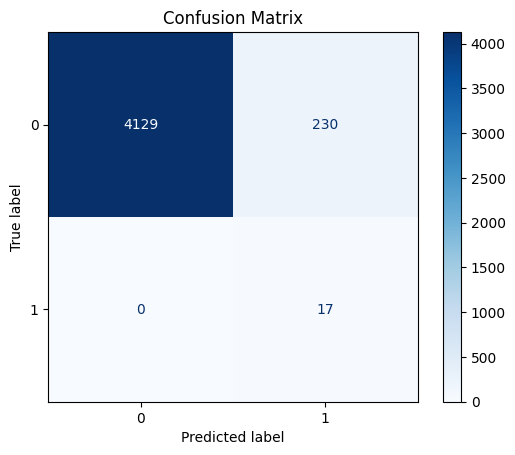


📊 مرحله ۶: ویژگی های مهم

🔍 Computing permutation importance on combined features...

📊 Permutation Importance Scores:
   Feature  Importance
7       F7    0.041642
16     F16    0.025473
4       F4    0.008725
0       F0    0.004787
14     F14    0.004004
21     F21    0.003460
12     F12    0.003225
20     F20    0.002119
8       F8    0.001893
9       F9    0.001822
17     F17    0.001512
1       F1    0.000916
6       F6    0.000194
5       F5    0.000161
15     F15    0.000073
22     F22    0.000000
19     F19    0.000000
11     F11    0.000000
13     F13   -0.001416
3       F3   -0.002022
2       F2   -0.003381
10     F10   -0.006394
18     F18   -0.008005

✅ Selected 11 features out of 23

🔁 Retraining XGBoost on selected features...

📊 Evaluation Report:

              precision    recall  f1-score   support

         0.0     0.9995    0.9984    0.9990      4359
         1.0     0.6818    0.8824    0.7692        17

    accuracy                         0.9979      4376
   macr

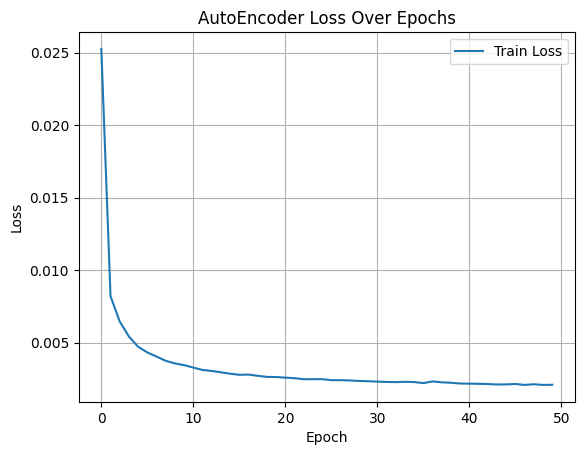

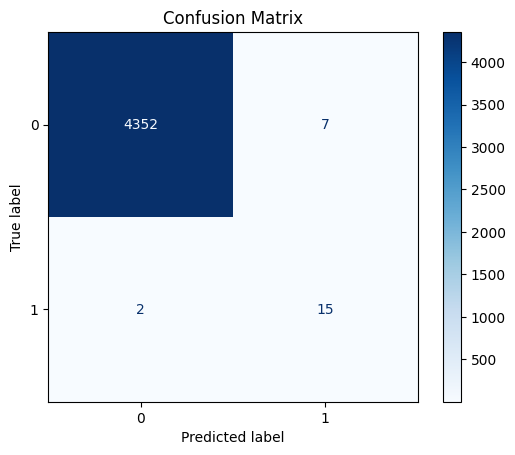

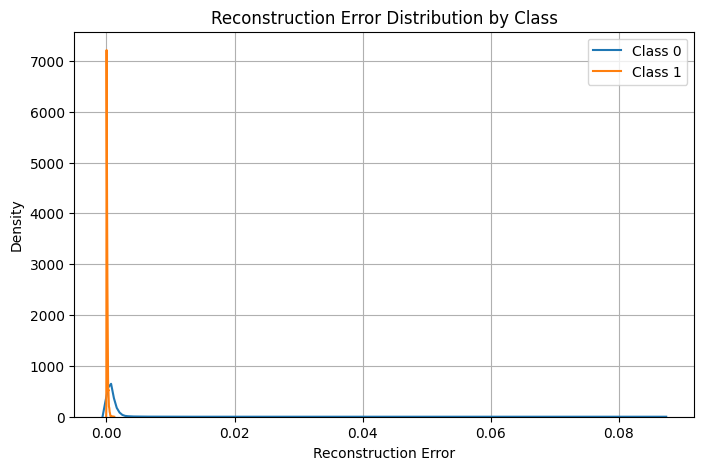

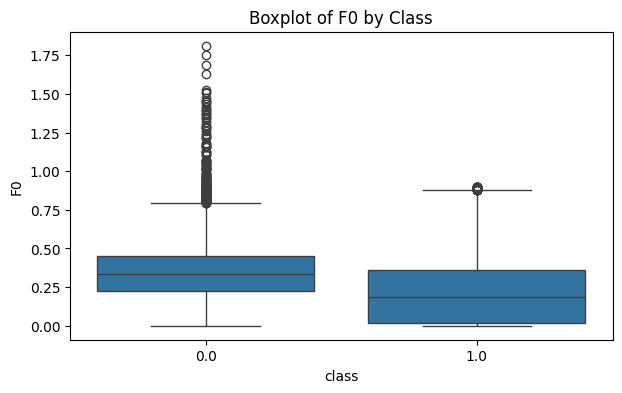

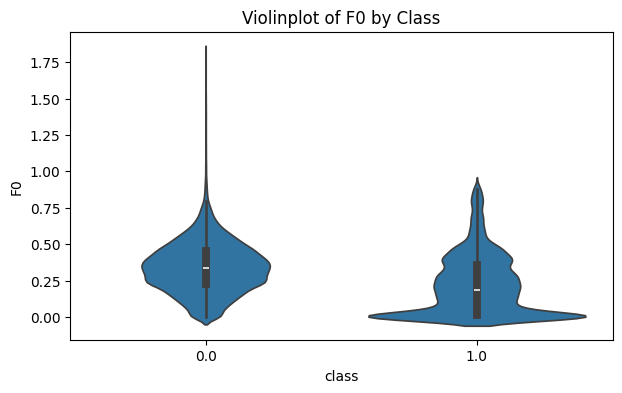

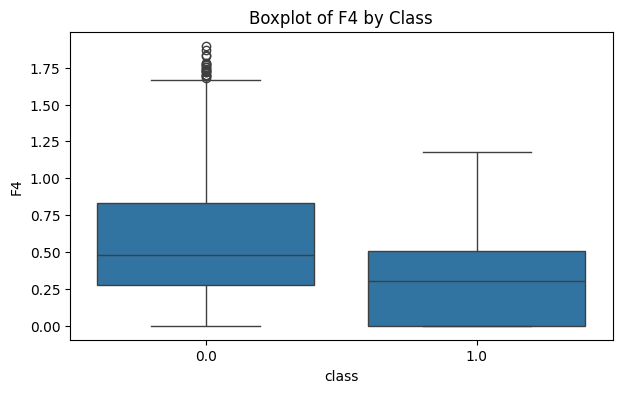

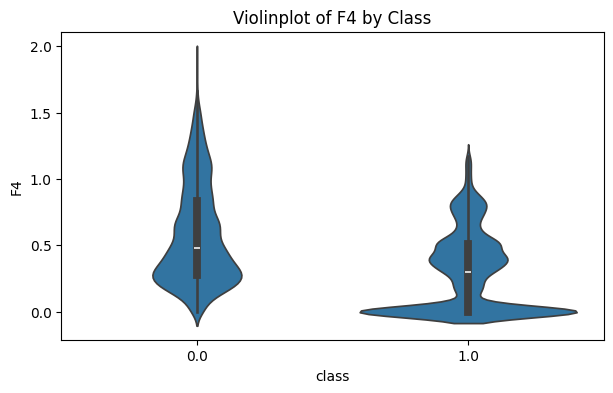

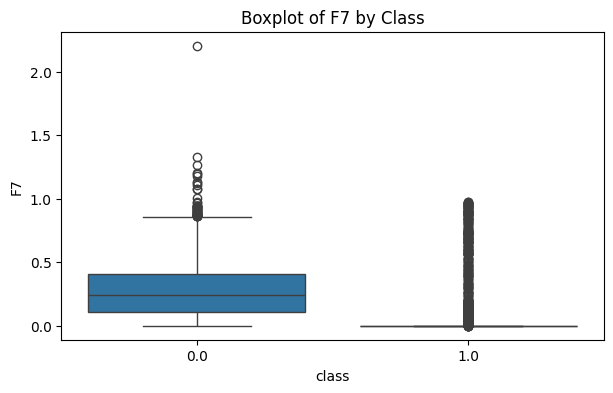

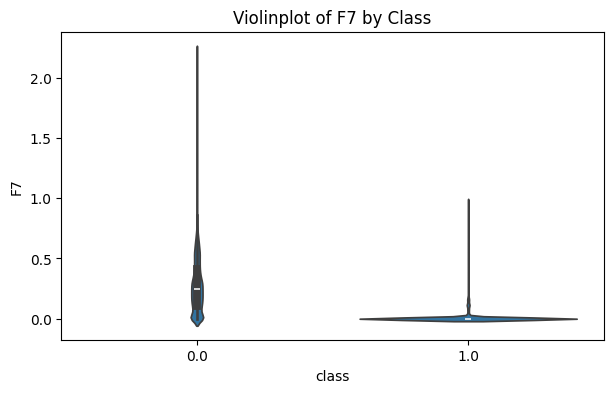

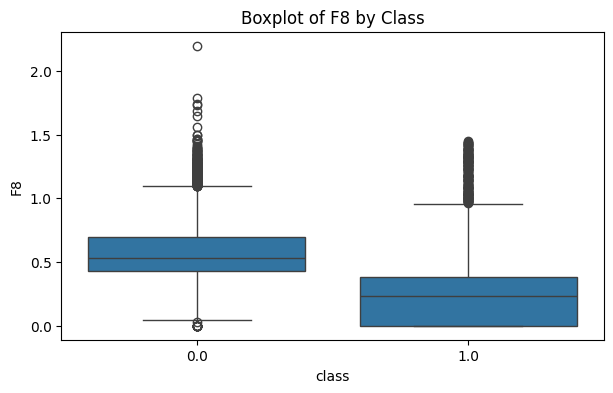

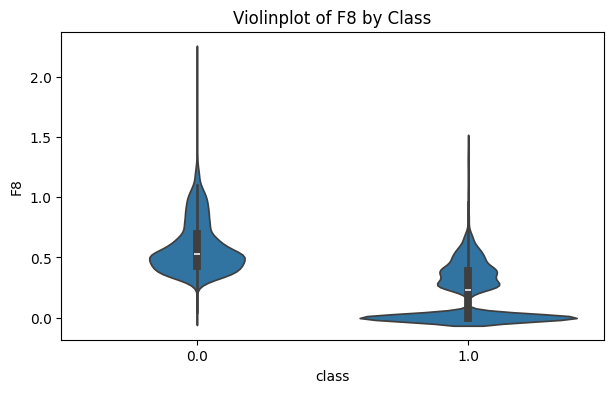

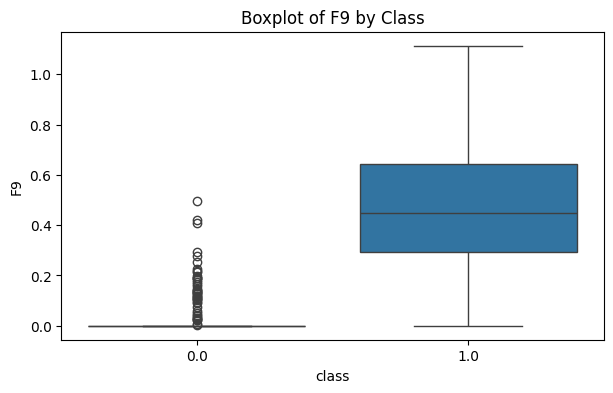

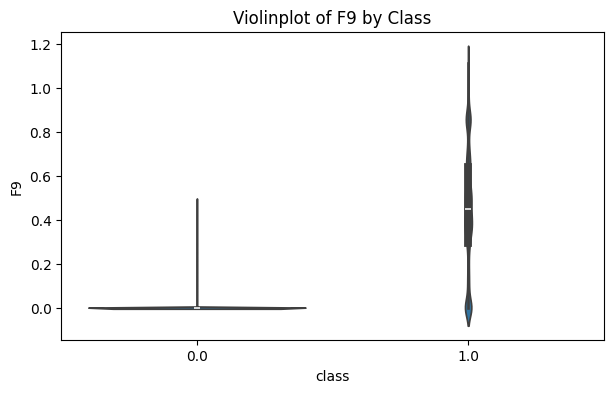

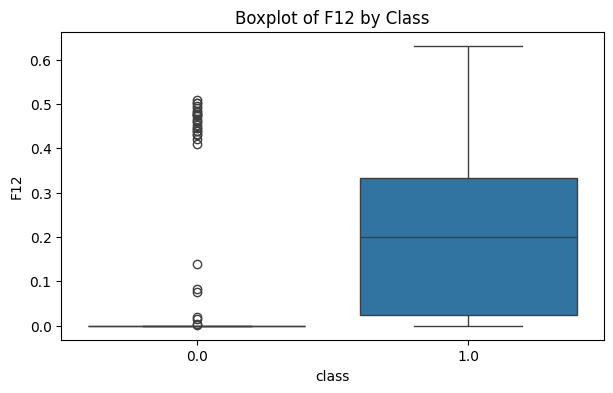

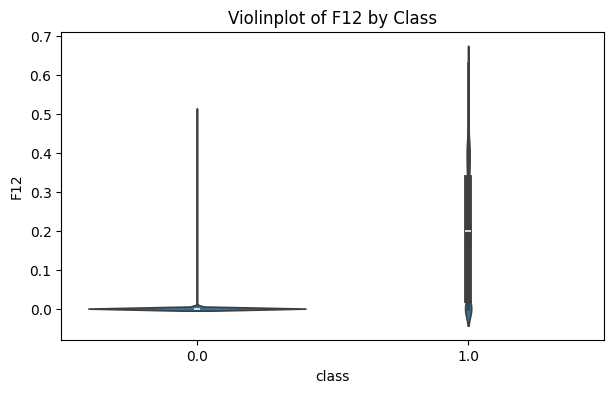

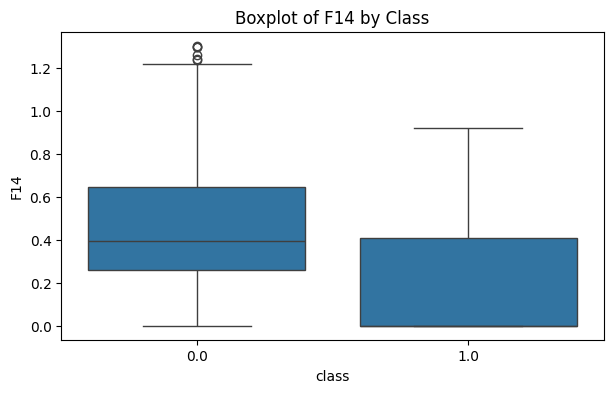

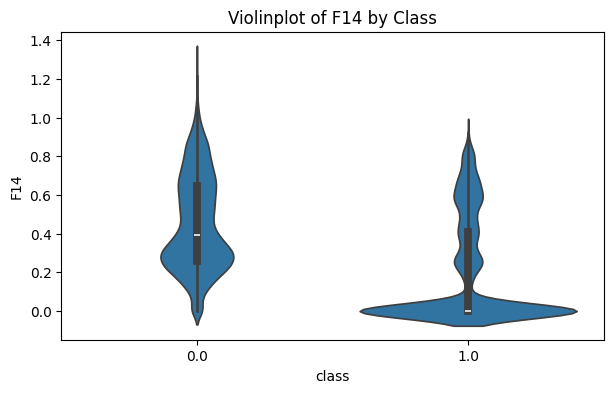

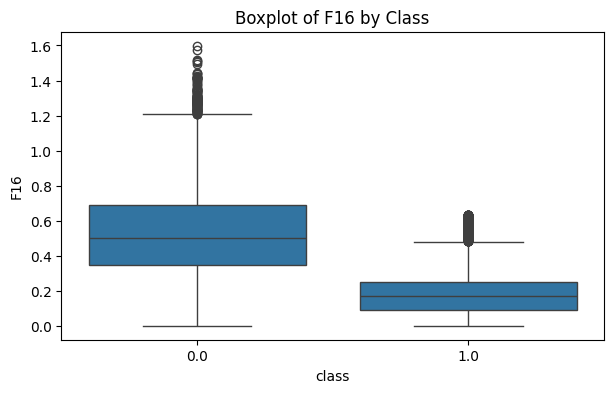

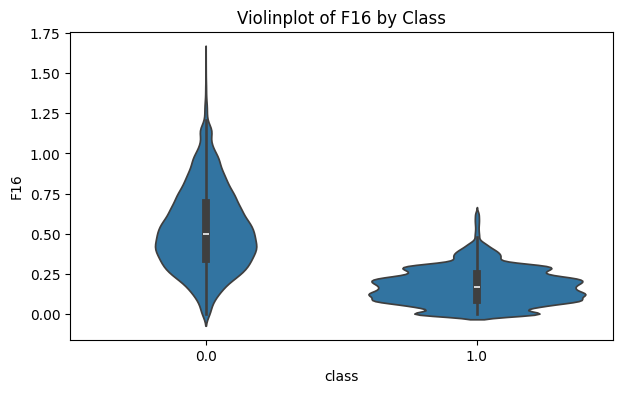

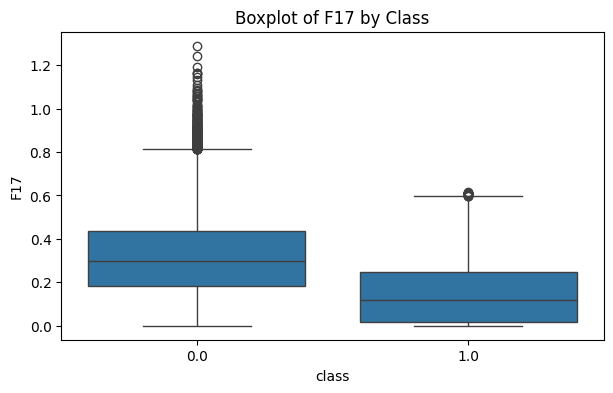

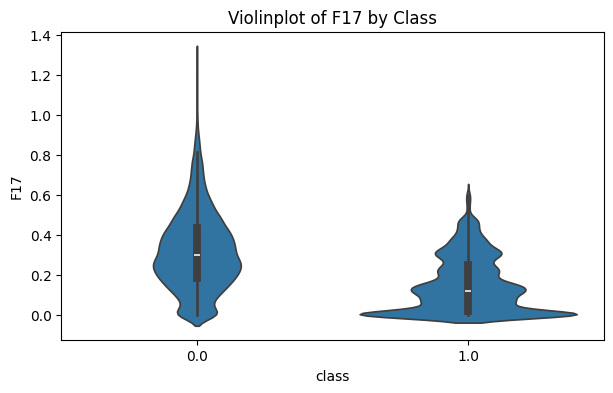

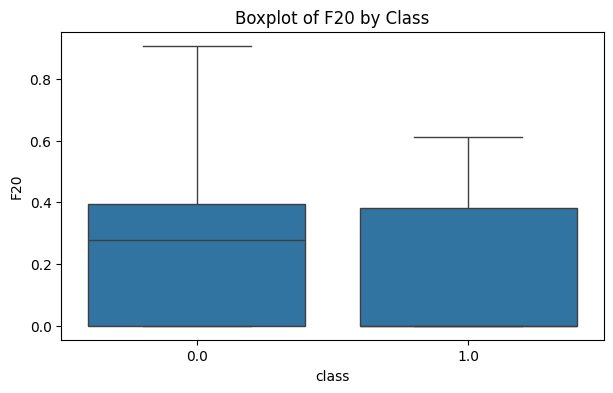

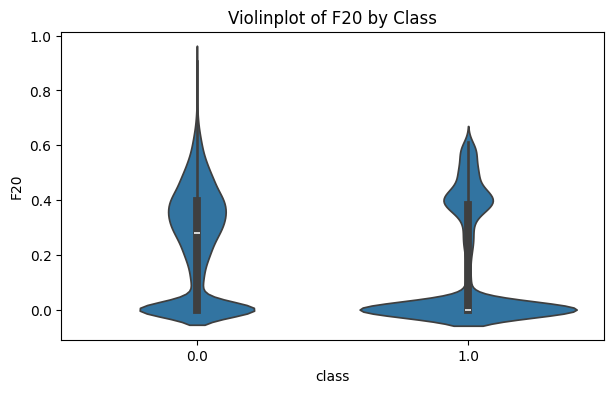

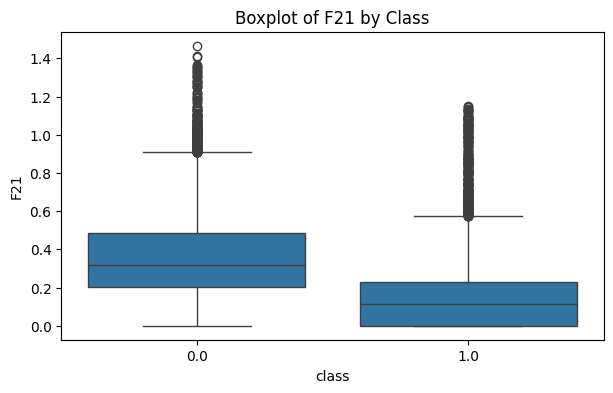

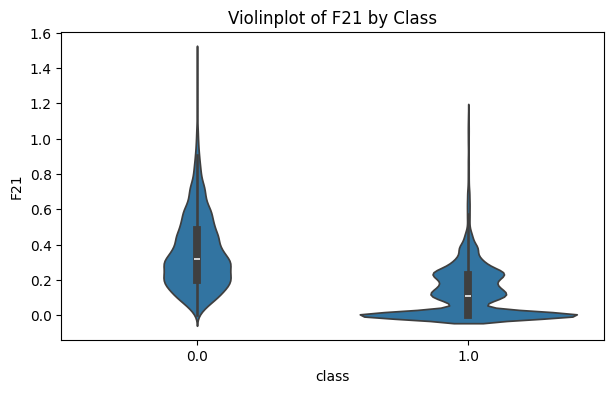

📊 SHAP Summary Plot برای کلاس ۱:


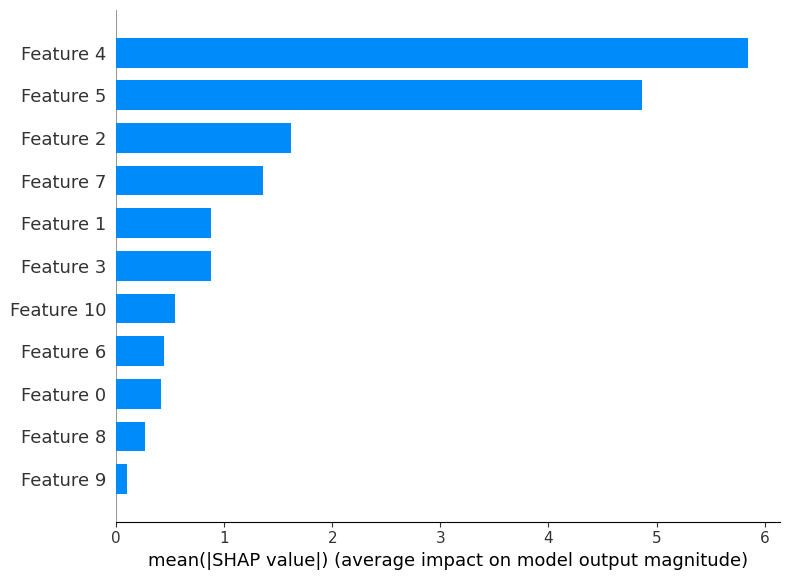


📍 Waterfall Plot برای نمونه شماره 775 (کلاس ۱):


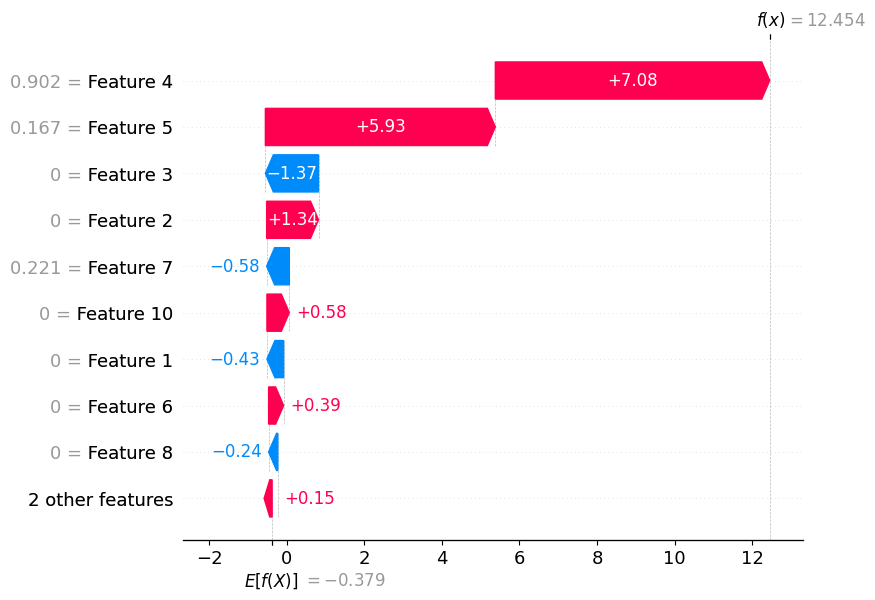


📍 Waterfall Plot برای نمونه شماره 1217 (کلاس ۱):


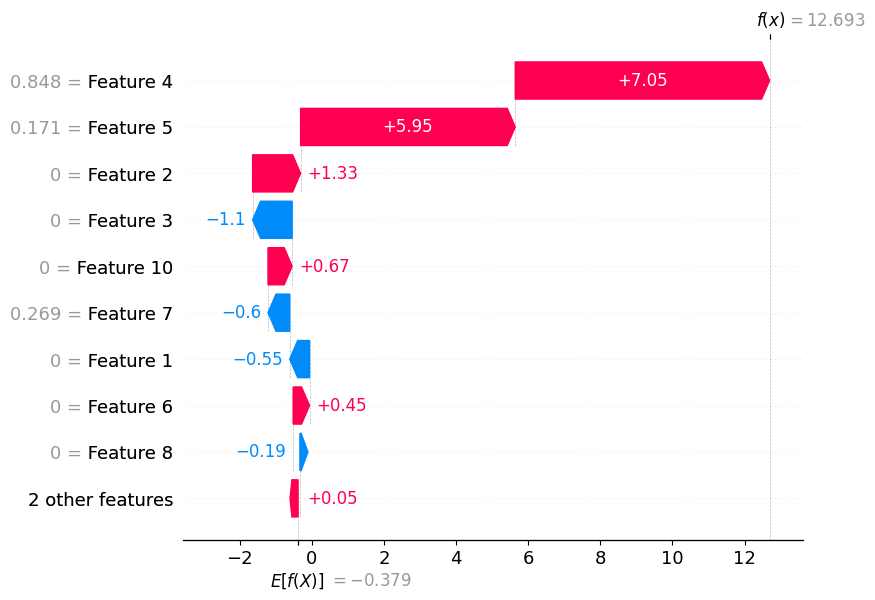


📍 Waterfall Plot برای نمونه شماره 1913 (کلاس ۱):


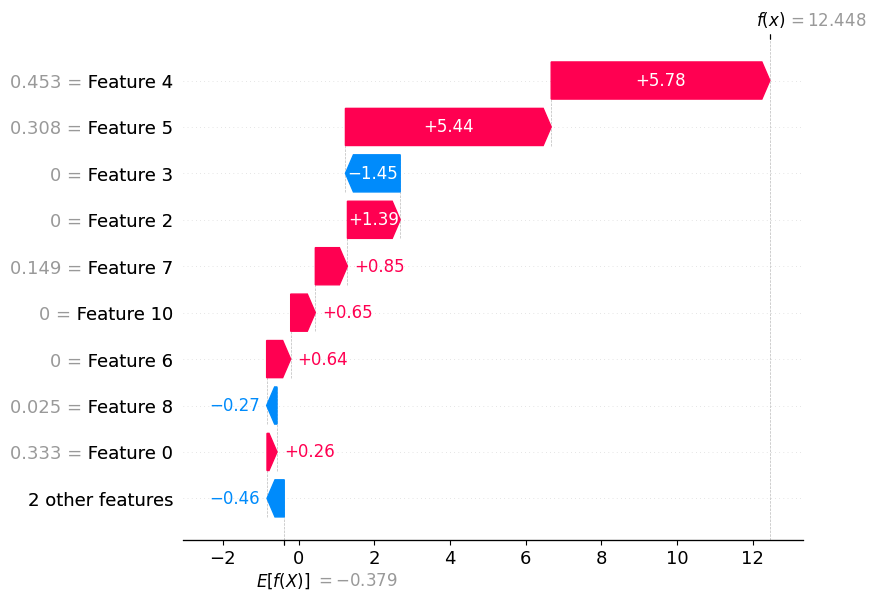


📍 Waterfall Plot برای نمونه شماره 2140 (کلاس ۱):


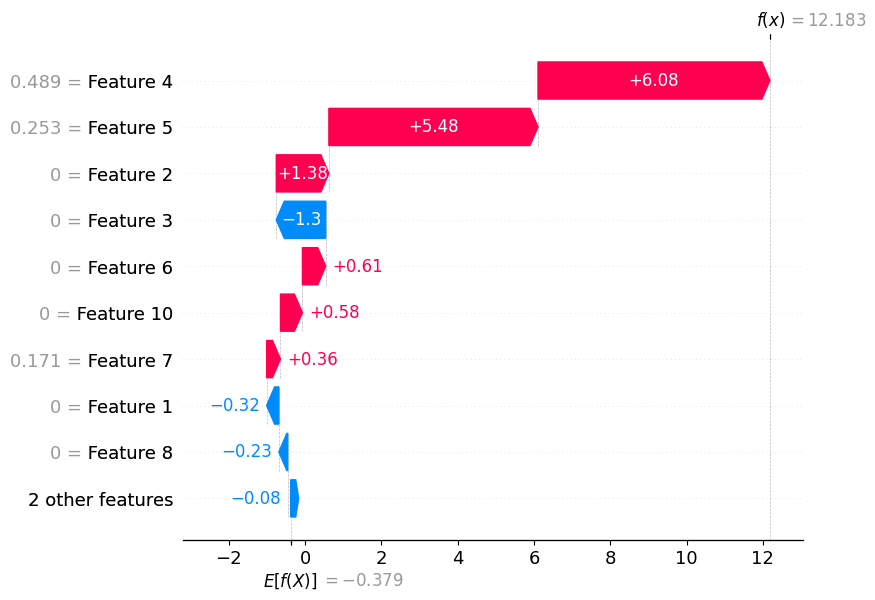


📍 Waterfall Plot برای نمونه شماره 2166 (کلاس ۱):


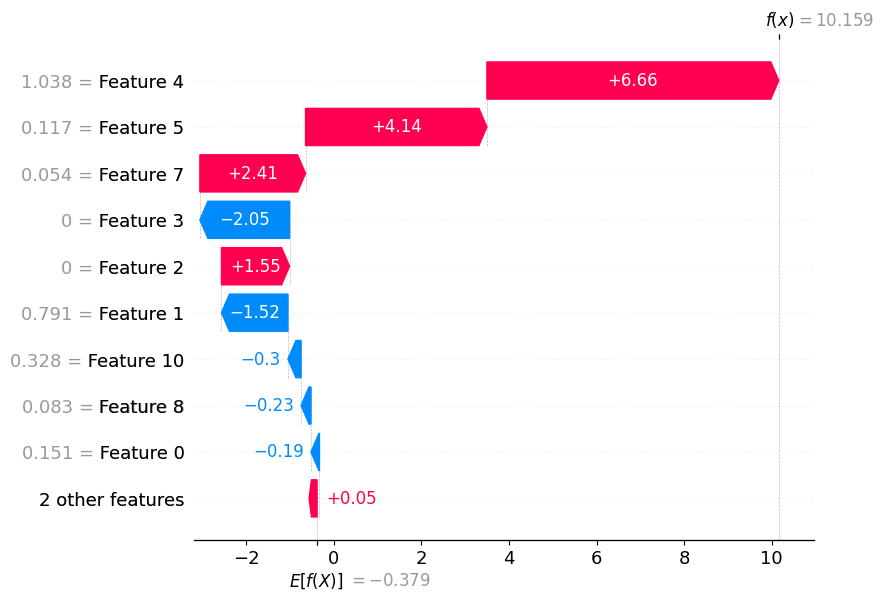

In [7]:
framework.run_pipeline()

In [8]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

class AdvancedFraudVisualizer(FraudDetectionFramework):
    def get_feature_weighting_layer(self):
        for layer in self.ae_model.layers:
            if isinstance(layer, FeatureWeighting):
                return layer
        raise ValueError("❌ هیچ لایه‌ای از نوع FeatureWeighting در مدل پیدا نشد.")

    def plot_feature_weights(self):
        try:
            layer = self.get_feature_weighting_layer()
            weights = layer.get_weights()[0]

            plt.figure(figsize=(10, 5))
            plt.bar(range(len(weights)), weights)
            plt.title("Feature Weights Learned by AutoEncoder")
            plt.xlabel("Feature Index")
            plt.ylabel("Weight")

            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"❌ خطا در استخراج وزن ویژگی‌ها: {e}")

    def plot_permutation_importance(self):
      try:
        print(type(self.perm_df))
      except Exception as e:
        print(f'خطا هنگام دسترسي به perm_df:{e}')
        return
      if hasattr(self, 'perm_df'):
        try:
            plt.figure(figsize=(10, 5))
            sns.barplot(data=self.perm_df, x="Importance", y="Feature", palette="mako")
            plt.title("Feature Importance (Permutation Importance)")
            plt.xlabel("Mean Importance")
            plt.ylabel("features")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
          print(f"خطا در رسم نمودار:{e}")
      else:
            print("⚠️ perm_df وجود ندارد.خطا")


    def plot_precision_recall_curve(self, X_test, y_test):
        try:
            y_proba = self.xgb_model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            disp = PrecisionRecallDisplay(precision=precision, recall=recall)
            disp.plot()
            plt.title("Precision-Recall Curve")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"❌ خطا در رسم precision-recall curve: {e}")

    def plot_shap_summary_class0(self, X, y):

        X = np.array(X)
        if isinstance(y, pd.DataFrame):
            y = y.values.ravel()
        elif isinstance(y, pd.Series):
            y = y.values

        explainer = shap.Explainer(self.xgb_model)
        shap_values = explainer(X)

        mask = (y == 0)
        if not mask.any():
            print("⚠️ هیچ نمونه‌ای با کلاس ۰ در داده‌ها وجود ندارد.")
            return

        print("📊 SHAP Summary Plot برای کلاس ۰:")
        shap.summary_plot(shap_values[mask], X[mask], plot_type="bar")




In [9]:
# ساخت شی از کلاس تصویری
viz = AdvancedFraudVisualizer(df, config={
    "output_dir": "output",
    "encoding_ratio": 0.75,
    "dropout": 0.3,
    "lr": 1e-3,
    "ae_epochs": 50,
    "batch_size": 32,
    "ae_class0_weight": 1.0,
    "ae_class1_weight": 10.0,
    "ae_weighted_loss": True,
    "xgb_weight": 70  # وزن کلاس اقلیت برای XGBoost
})




Class Distribution:
 Class
0.0    0.996069
1.0    0.003931
Name: proportion, dtype: float64
Calculated scale_pos_weight: 70.00


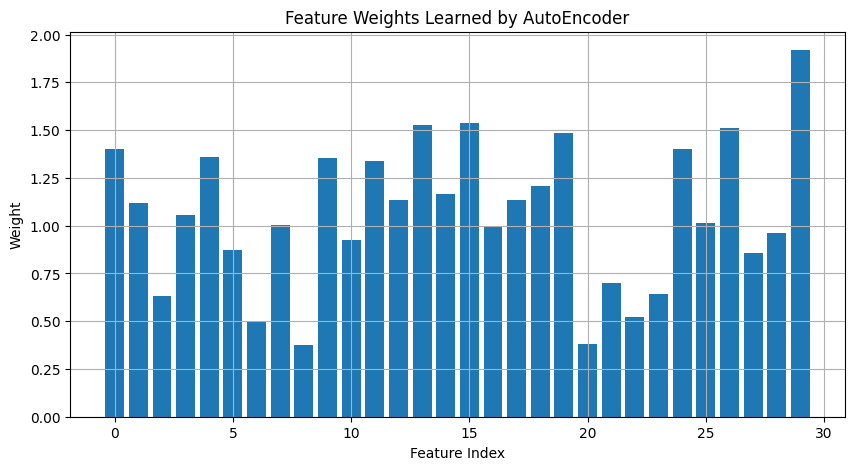

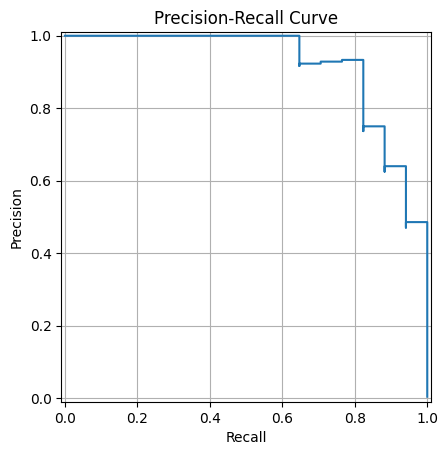

📊 SHAP Summary Plot برای کلاس ۰:


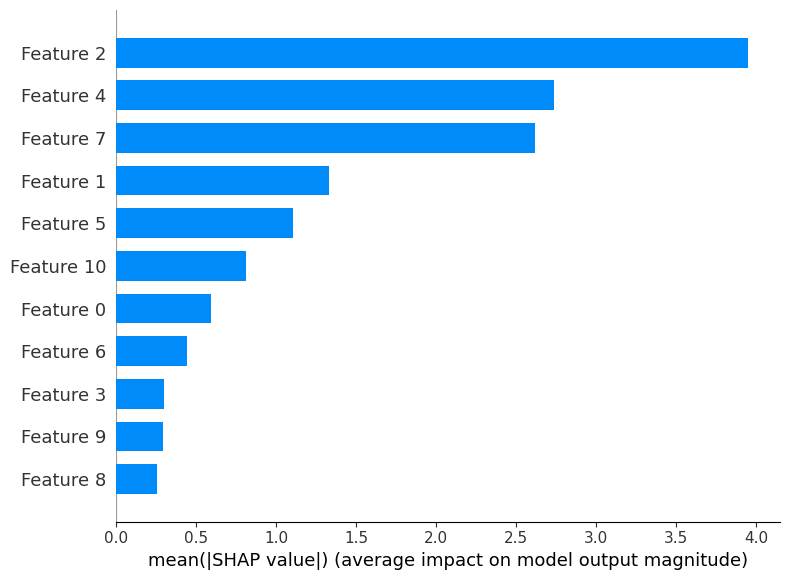

In [10]:

viz.ae_model = framework.ae_model
viz.xgb_model = framework.xgb_model
viz.X_test_selected = framework.X_test_selected
viz.y_test = framework.y_test
viz.plot_feature_weights()
viz.plot_precision_recall_curve(viz.X_test_selected, viz.y_test)
viz.plot_shap_summary_class0(viz.X_test_selected, viz.y_test)


<class 'pandas.core.frame.DataFrame'>


/tmp/ipython-input-8-2340358713.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=self.perm_df, x="Importance", y="Feature", palette="mako")


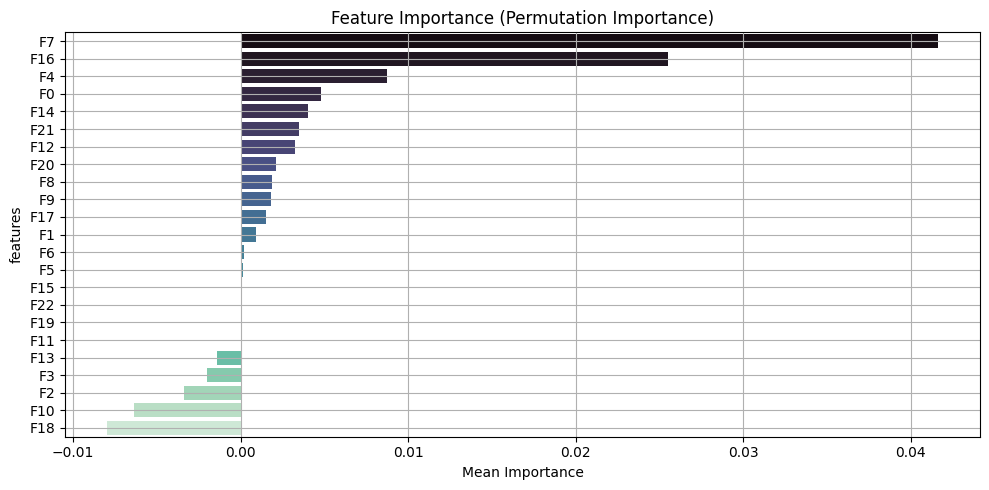

In [11]:
viz.perm_df=framework.perm_df
viz.plot_permutation_importance()